<a href="https://colab.research.google.com/github/syahrinalfi/MachineLearningTasks/blob/main/9thWeekTasks/9_Credit_Card_Fraud_Detection_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Nama : Muhammad Alfi Syahrin
* NIM : 1103213144
* Lecture : Tugas Pengganti UTS
* Model : Random Forest Classifier
* Dataset : [Credit Score Classification](https://www.kaggle.com/datasets/parisrohan/credit-score-classification)


# Import Library

In [4]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from math import sqrt
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error
from imblearn.over_sampling import SMOTE

# Load File

In [5]:
# Mount drive dan baca data dari file CSV
drive.mount('/content/drive')
url = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/Dataset/train.csv"
df = pd.read_csv(url)

Mounted at /content/drive


<ipython-input-5-f51d490b4c71>:4: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


# Data Cleaning

In [6]:
# Informasi dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  object 
 1   Customer_ID               100000 non-null  object 
 2   Month                     100000 non-null  object 
 3   Name                      90015 non-null   object 
 4   Age                       100000 non-null  object 
 5   SSN                       100000 non-null  object 
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  object 
 8   Monthly_Inhand_Salary     84998 non-null   float64
 9   Num_Bank_Accounts         100000 non-null  int64  
 10  Num_Credit_Card           100000 non-null  int64  
 11  Interest_Rate             100000 non-null  int64  
 12  Num_of_Loan               100000 non-null  object 
 13  Type_of_Loan              88592 non-null   ob

Dari Output dapat dilihat bahwa masih banyak data yang tipenya tidak sesuai dan terdapat juga yang memiliki null value. Karena itu perlu dilakukan cleaning.

## Data Format

In [7]:
# Melakukan pengisian data yang kosong, melakukan pengambilan angka saja tanpa karakter pada kolom tertentu, dan mengubah tipe kolom menjadi integer
df['Age'] = df['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
df['Num_of_Loan'] = df['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

In [8]:
# Mengambil semua nilai berbentuk angka dan menyimpannya kembali dalam bentuk float
df['Annual_Income'] = df['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
df['Annual_Income'] = df['Annual_Income'].astype(float)

In [9]:
# Mengubah nilai _ menjadi NaN, mengubah kolom menjadi numerik, dan mengisi nilai kolom menjadi 0 jika kolom berisi NaN
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].replace('_', np.nan)
df['Changed_Credit_Limit'] = pd.to_numeric(df['Changed_Credit_Limit'], errors='coerce')
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].fillna(0)

In [10]:
# Mengubah kolom menjadi bentuk string, mengambil angka dalam kolom, mengubah kolom menjadi numerik, dan mengisi nilai kolom kosong menjadi 0
df['Outstanding_Debt'] = df['Outstanding_Debt'].astype(str)
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
df['Outstanding_Debt'] = pd.to_numeric(df['Outstanding_Debt'], errors='coerce')
df['Outstanding_Debt'] = df['Outstanding_Debt'].fillna(0)

In [11]:
# Mengubah kolom menjadi bentuk string, mengambil mengganti nilai yang kosong menjadi 0, mengambil angka dalam kolom,
# mengubah kolom menjadi numerik, dan mengisi kolom yang kosong dengan 0
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].astype(str)
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].replace('', '0')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
df['Amount_invested_monthly'] = pd.to_numeric(df['Amount_invested_monthly'], errors='coerce')
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].fillna(0)

In [12]:
# Mengubah kolom menjadi bentuk string, mengambil mengganti nilai yang kosong menjadi 0, mengambil angka dalam kolom,
# mengubah kolom menjadi numerik, dan mengisi kolom yang kosong dengan 0
df['Monthly_Balance'] = df['Monthly_Balance'].astype(str)
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce')
df['Monthly_Balance'] = df['Monthly_Balance'].fillna(0)

In [13]:
# Mengubah kolom Credit_History_Age_Months yang tadinya berisi tahun dan bulan dikonversi menjadi bulan
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

df['Credit_History_Age_Months'] = df['Credit_History_Age'].apply(parse_years_and_months)

## Duplicates

In [14]:
# Mencari jumlah data duplikat dalam dataset
duplicates = df[df.duplicated()]
num_duplicates = duplicates.shape[0]

if num_duplicates == 0:
    print("Tidak ada duplikat")
else:
    print("Terdapat", num_duplicates, "duplikat.")

Tidak ada duplikat


Dari output dapat diketahui bahwa dataset yang digunakan tidak memiliki data duplikat

## Data Scaling

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,119.509700,6.847573e+02,14.000000,25.000000,34.000000,42.000000,8.698000e+03
Annual_Income,100000.0,176415.701298,1.429618e+06,7005.930000,19457.500000,37578.610000,72790.920000,2.419806e+07
Monthly_Inhand_Salary,84998.0,4194.170850,3.183686e+03,303.645417,1625.568229,3093.745000,5957.448333,1.520463e+04
Num_Bank_Accounts,100000.0,17.091280,1.174048e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,100000.0,22.474430,1.290574e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,100000.0,72.466040,4.664226e+02,1.000000,8.000000,13.000000,20.000000,5.797000e+03
Num_of_Loan,100000.0,10.761960,6.178993e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,100000.0,21.068780,1.486010e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,100000.0,28.779410,2.181148e+02,0.000000,8.000000,13.000000,18.000000,4.397000e+03
Changed_Credit_Limit,100000.0,10.171791,6.880628e+00,-6.490000,4.970000,9.250000,14.660000,3.697000e+01


In [16]:
# Menghilangkan data outlier sebanyak 2% dari kolom yang dipilih
selected_columns_df = df[['Num_Bank_Accounts', 'Interest_Rate', 'Annual_Income', 'Num_of_Delayed_Payment',
                             'Num_Credit_Inquiries', 'Total_EMI_per_month', 'Num_of_Loan', 'Num_Credit_Card']]

percentile_threshold = 0.98
percentiles = selected_columns_df.quantile(percentile_threshold)

for column in selected_columns_df.columns:
    df = df[df[column] <= percentiles[column]]

In [17]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85806.0,120.486003,690.067511,14.000000,25.000000,34.000000,42.000000,8698.000000
Annual_Income,85806.0,49378.620726,36478.390299,7005.930000,19294.460000,36780.030000,70825.760000,166837.640000
Monthly_Inhand_Salary,72894.0,4105.781241,3036.319177,303.645417,1623.778333,3069.091667,5899.970000,14131.123333
Num_Bank_Accounts,85806.0,5.372759,2.585031,-1.000000,3.000000,6.000000,7.000000,10.000000
Num_Credit_Card,85806.0,5.779048,5.727016,0.000000,4.000000,5.000000,7.000000,171.000000
Interest_Rate,85806.0,14.551174,8.824173,1.000000,7.000000,13.000000,20.000000,128.000000
Num_of_Loan,85806.0,7.318381,18.881665,0.000000,2.000000,3.000000,6.000000,100.000000
Delay_from_due_date,85806.0,21.033483,14.786223,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_of_Delayed_Payment,85806.0,12.348321,6.845002,0.000000,8.000000,13.000000,18.000000,25.000000
Changed_Credit_Limit,85806.0,10.189597,6.867078,-6.490000,4.990000,9.280000,14.710000,36.970000


Dari hasil output dapat dilihat bahwa data sudah berkurang dan pada max terlihat nilainya sudah berubah

## Data Entry Plus

### Filtering

In [18]:
# Mengambil data dengan payment_behavior yang benar
df = df[df['Payment_Behaviour'] != '!@9#%8']

In [19]:
# Menhapus baris yang memiliki nilai '_______' pada kolom Occupation
df = df[df['Occupation'] != '_______']
print(df['Occupation'].unique())

['Scientist' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer' 'Lawyer'
 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant' 'Musician'
 'Mechanic' 'Writer' 'Architect']


Dapat dilihat bahwa baris yang memiliki value '_______' sudah dihapus dalam dataframe

In [20]:
# Menghapus baris yang berisi '_' pada kolom Credit_Mix
df = df[df['Credit_Mix'] != '_']
print(df['Credit_Mix'].unique())

['Good' 'Standard' 'Bad']


Dapat dilihat bahwa baris yang memiliki value '_' sudah dihapus dalam dataframe

### Negative Values

In [21]:
# Menghapus baris yang memiliki nilai negatif pada kolom tertentu di dataframe
selected_columns = ['Delay_from_due_date', 'Changed_Credit_Limit', 'Num_Bank_Accounts']

for column in selected_columns:
    df = df[df[column] >= 0]

## Drop Column

In [22]:
# Menghapus kolom yang kurang berguna untuk pelatihan model

columns_to_drop = ['ID', 'Customer_ID', 'Month', 'Name', 'SSN', 'Credit_History_Age','Monthly_Inhand_Salary', 'Type_of_Loan']
df.drop(columns=columns_to_drop, inplace=True)

## Missing Values

In [23]:
# Mencari baris yang masih memiliki null value pada salah satu kolom
total_missing_values = df.isnull().sum().sum()

if total_missing_values == 0:
    print("Tidak ada missing value")
else:
    print("Total missing values:", total_missing_values)

Tidak ada missing value


Dari output dapat diketahui bahwa dataframe yang sudah dibersihkan tadi sudah tidak memiliki baris yang memiliki null value

# Feature Engineering

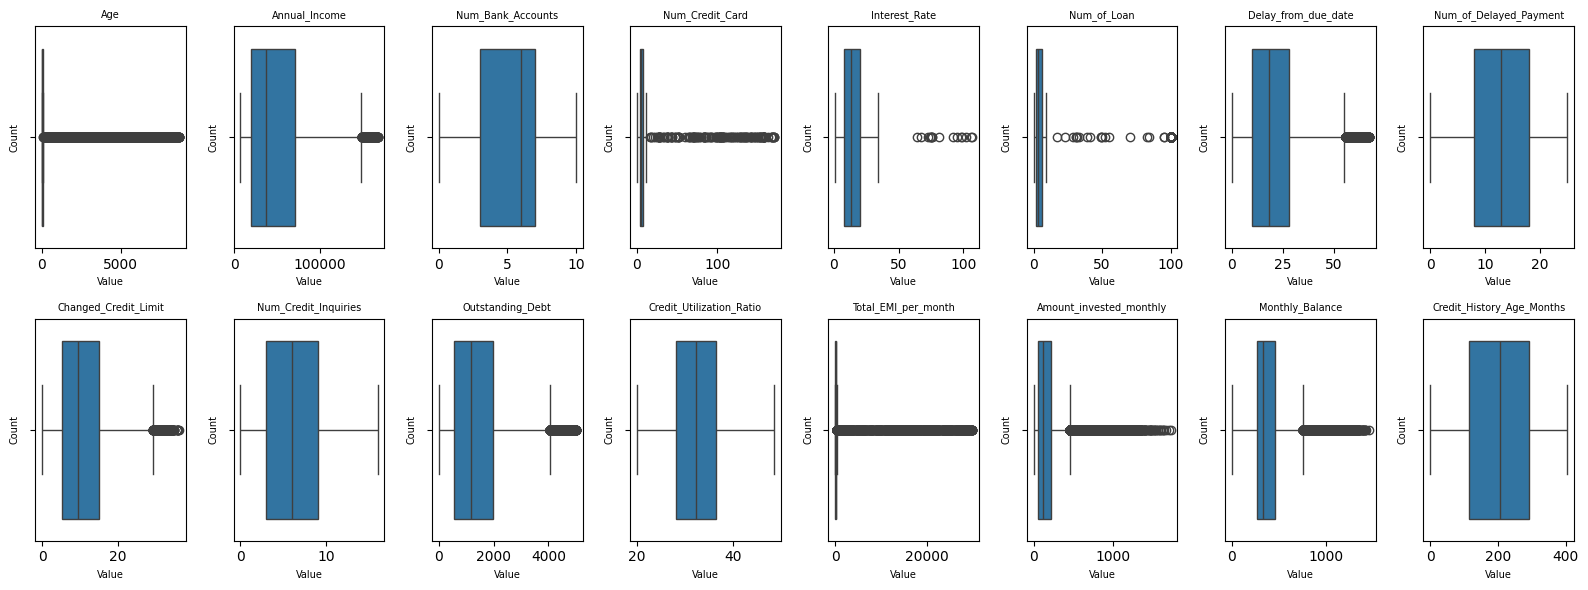

In [24]:
# Menampilkan grafik boxplot untuk kolom numerik
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

num_columns = 8
num_rows = (len(numeric_columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 6))

axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(x=df[column], ax=axes[i])
    axes[i].set_title(column, fontsize=7)
    axes[i].set_xlabel('Value', fontsize=7)
    axes[i].set_ylabel('Count', fontsize=7)

for j in range(len(numeric_columns), num_columns*num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Dapat dilihat bahwa sebagian besar data outlier sudah dibersihkan menggunakan kode sebelumnya

## Scaling 2.0

In [25]:
# Memberikan batas wajar untuk masing-masing nilai pada kolom

df = df[df['Age'] < 60]
df = df[df['Num_Credit_Card'] <= 10]
df = df[df['Interest_Rate'] <= 50]
df = df[df['Num_of_Loan'] <= 12]
df = df[df['Num_Bank_Accounts'] <= 10]
df = df[df['Delay_from_due_date'] <= 60]
df = df[df['Changed_Credit_Limit'] <= 30]
df = df[df['Num_Credit_Inquiries'] <= 12]
df = df[df['Total_EMI_per_month'] <= 200]
df = df[df['Outstanding_Debt'] <= 1500]

## Encoding

### Label Encoder

In [26]:
# Memberikan label baru untuk Credit_Score agar bisa digunakan dalam model
categories = ['Poor', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])
df['Credit_Score_Encoded'] = encoder.fit_transform(df[['Credit_Score']])

In [27]:
# Memberikan label baru untuk Occupation
label_encoder = LabelEncoder()
df['Occupation_Encoded'] = label_encoder.fit_transform(df['Occupation'])

### Ordinal Encoder

In [28]:
# Memberikan label baru untuk kolom Credit_Mix
categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])
df['Credit_Mix_Encoded'] = encoder.fit_transform(df[['Credit_Mix']])

In [29]:
# Memberikan label baru untuk kolom Payment_Behaviour
categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

df['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(df[['Payment_Behaviour']])

In [30]:
# Menghapus kolom yang lama
columns_to_drop = [ 'Payment_Behaviour', 'Credit_Mix', 'Occupation','Credit_Score']
df.drop(columns=columns_to_drop, inplace=True)

## New Features

In [31]:
# Menjumlahkan jumlah akun yang dimiliki (Bank Accounts + Credit Cards)
df['Total_Num_Accounts'] = df['Num_Bank_Accounts'] + df['Num_Credit_Card']

# Menghitung outstanding debt untuk tiap akun
df['Debt_Per_Account'] = df['Outstanding_Debt'] / df['Total_Num_Accounts']

# Menghitung rasio outstanding debt dengan annual income
df['Debt_to_Income_Ratio'] = df['Outstanding_Debt'] / df['Annual_Income']

# Menghitung banyak delayed payment tiap akun
df['Delayed_Payments_Per_Account'] = df['Num_of_Delayed_Payment'] / df['Total_Num_Accounts']

# Menghitung pengeluaran tiap bulan (EMI + Monthly Investments)
df['Total_Monthly_Expenses'] = df['Total_EMI_per_month'] + df['Amount_invested_monthly']

## Mutual Information Score (MI Score)

In [32]:
# Mencari variabel paling berguna untuk melakukan prediksi
categorical_columns = df.select_dtypes(include=['object']).columns

data_encoded = df.copy()

encoder = OrdinalEncoder()
data_encoded[categorical_columns] = encoder.fit_transform(data_encoded[categorical_columns])

y = data_encoded['Credit_Score_Encoded']
X = data_encoded.drop(columns=['Credit_Score_Encoded'])

mi_scores = mutual_info_classif(X, y)

for i, score in enumerate(mi_scores):
    print(f"Feature '{X.columns[i]}': Mutual Information Score = {score}")

Feature 'Age': Mutual Information Score = 0.007301287947008683
Feature 'Annual_Income': Mutual Information Score = 0.42936316831787913
Feature 'Num_Bank_Accounts': Mutual Information Score = 0.05758771389262041
Feature 'Num_Credit_Card': Mutual Information Score = 0.07631452841853026
Feature 'Interest_Rate': Mutual Information Score = 0.0992678282952082
Feature 'Num_of_Loan': Mutual Information Score = 0.01786692644275223
Feature 'Delay_from_due_date': Mutual Information Score = 0.0727352910438892
Feature 'Num_of_Delayed_Payment': Mutual Information Score = 0.05044100636090065
Feature 'Changed_Credit_Limit': Mutual Information Score = 0.10128473981665698
Feature 'Num_Credit_Inquiries': Mutual Information Score = 0.034737382540706685
Feature 'Outstanding_Debt': Mutual Information Score = 0.4299287237079319
Feature 'Credit_Utilization_Ratio': Mutual Information Score = 0.0008940600062685711
Feature 'Payment_of_Min_Amount': Mutual Information Score = 0.07478164121843389
Feature 'Total_EMI

In [33]:
# Menampilkan hasil keluaran dalam bentuk grafik
sorted_mi_scores = sorted(zip(X.columns, mi_scores), key=lambda x: x[1], reverse=True)
sorted_columns = [x[0] for x in sorted_mi_scores]
sorted_scores = [x[1] for x in sorted_mi_scores]

colorscale = 'Viridis'

fig = go.Figure(data=[go.Bar(x=sorted_columns, y=sorted_scores, marker=dict(color=sorted_scores, colorbar=dict(title='Mutual Information Score', len=0.5, y=0.2)))])

fig.update_layout(title='Mutual Information Scores untuk Setiap Fitur Terhadap Credit_Score',
                  xaxis_title='Features',
                  yaxis_title='Mutual Information Score')

fig.show()

Dari hasil output dapat dilihat bahwa terdapat kolom yang memiliki pengaruh terhadap credit_score dan yang tidak memiliki pengaruh. Dapat diketahui terdapat 4 kolom yang memiliki tingkat hubungan tertinggi, yaitu Debt_to_Income_Ratio, Debt_per_Account, Annual_Income, dan Outstandint_Debt dengan nilai melebihi 0.4

In [34]:
# Menghapus kolom yang tidak memiliki pengaruh besar terhadap kolom yang akan diprediksi

columns_to_drop = [ 'Payment_of_Min_Amount', 'Age', 'Monthly_Balance', 'Total_Monthly_Expenses', 'Payment_Behaviour_Encoded', 'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Occupation_Encoded']
df.drop(columns=columns_to_drop, inplace=True)

# Machine Learning Model

## Pembagian Data Menggunakan SMOTE

In [35]:
smote_params = {
    'sampling_strategy': 'auto',
    'random_state': 77,
    'k_neighbors': 5,
    'n_jobs': -1
}

smote = SMOTE(**smote_params)

X_train = df.drop('Credit_Score_Encoded', axis=1)
y_train = df['Credit_Score_Encoded']

X_smote, y_smote = smote.fit_resample(X_train, y_train)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X_smote, y_smote, test_size=0.15, random_state=77)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning:

The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.



SMOTE digunakan untuk menyeimbangkan data jika persebaran data klasifikasi target tidak merata, dilakukan dengan cara membuat sampel sintetis dari kelas minoritas untuk menyeimbangkan distribusi kelas dalam dataset.

## Random Forest Classifier

In [36]:
# Membuat model random forest classifier dengan banyak pohon 500
rf_classifier = RandomForestClassifier(n_estimators=500, bootstrap=True)
rf_classifier.fit(X_train_smote, y_train_smote)

RandomForestClassifier(n_estimators=500)

# Model Evaluation

In [37]:
# Melihat akurasi untuk data training dengan data test
print("Accuracy on training set:", rf_classifier.score(X_train_smote, y_train_smote))

y_pred_smote = rf_classifier.predict(X_test_smote)
accuracy_smote = accuracy_score(y_test_smote, y_pred_smote)

print("Accuracy on SMOTE test set:", accuracy_smote)

Accuracy on training set: 0.9995520990268333
Accuracy on SMOTE test set: 0.8957083525611444


Dapat dilihat bahwa Random Forest Classifier memiliki akurasi menggunakan data train SMOTE sebesar 99% dan data test SMOTE sebesar 89%

In [38]:
# Membagi data lagi untuk melakukan pengujian dengan data asli
y = df['Credit_Score_Encoded']

X = df[['Annual_Income', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Total_EMI_per_month',
       'Credit_History_Age_Months', 'Credit_Mix_Encoded', 'Total_Num_Accounts',
       'Debt_Per_Account', 'Debt_to_Income_Ratio', 'Delayed_Payments_Per_Account']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

Akurasi data test asli: 0.9697313046293299
Mean Squared Error (MSE): 0.030754289414049854
Root Mean Squared Error (RMSE): 0.17536900927487117
Mean Absolute Error (MAE): 0.030430560051796698

Classification report for original test set:
               precision    recall  f1-score   support

         0.0       0.94      0.97      0.96       901
         1.0       0.99      0.97      0.98      3810
         2.0       0.95      0.98      0.96      1467

    accuracy                           0.97      6178
   macro avg       0.96      0.97      0.97      6178
weighted avg       0.97      0.97      0.97      6178



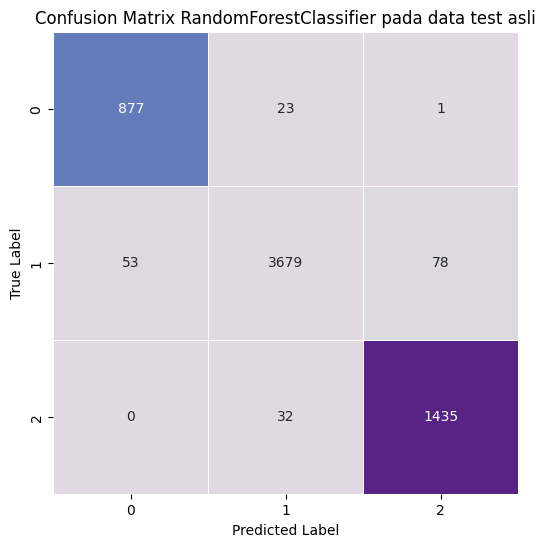

In [39]:
# Melakukan prediksi menggunakan data asli dan menampilkan akurasi dan confussion matrix
y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("Akurasi data test asli:", accuracy)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(matrix, annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix RandomForestClassifier pada data test asli')

print('\nClassification report for original test set:\n', classification_report(y_test, y_pred))

Dapat dilihat dari output bahwa ketika model dilakukan pengujian menggunakan data asli, akurasi yang dihasilkan adalah sebesar 97% dengan persebaran seperti yang terlihat pada confussion matrix. Prediksi juga menghasilkan nilai MSE sebesar 0.0312, MAE sebesar 0.0309, dan RMSE sebesar 0.1767

# Pengujian Pada Data Test

## Load File

In [40]:
# Mount File Train
url = "/content/drive/MyDrive/Colab Notebooks/Machine Learning/UTS/Dataset/test.csv"
test = pd.read_csv(url)

## Data Format

In [41]:
# Melakukan pengisian data yang kosong, melakukan pengambilan angka saja tanpa karakter pada kolom tertentu, dan mengubah tipe kolom menjadi integer
test['Age'] = test['Age'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
test['Num_of_Loan'] = test['Num_of_Loan'].fillna('0').str.extract('(\d+)').astype(float).astype(int)
test['Num_of_Delayed_Payment'] = test['Num_of_Delayed_Payment'].fillna('0').str.extract('(\d+)').astype(float).astype(int)

In [42]:
# Mengambil semua nilai berbentuk angka dan menyimpannya kembali dalam bentuk float
test['Annual_Income'] = test['Annual_Income'].str.replace(r'[^0-9.]', '', regex=True)
test['Annual_Income'] = test['Annual_Income'].astype(float)

In [43]:
# Mengubah nilai _ menjadi NaN, mengubah kolom menjadi numerik, dan mengisi nilai kolom menjadi 0 jika kolom berisi NaN
test['Changed_Credit_Limit'] = test['Changed_Credit_Limit'].replace('_', np.nan)
test['Changed_Credit_Limit'] = pd.to_numeric(test['Changed_Credit_Limit'], errors='coerce')
test['Changed_Credit_Limit'] = test['Changed_Credit_Limit'].fillna(0)

In [44]:
# Mengubah kolom menjadi bentuk string, mengambil angka dalam kolom, mengubah kolom menjadi numerik, dan mengisi nilai kolom kosong menjadi 0
test['Outstanding_Debt'] = test['Outstanding_Debt'].astype(str)
test['Outstanding_Debt'] = test['Outstanding_Debt'].str.replace(r'[^0-9.]', '', regex=True)
test['Outstanding_Debt'] = pd.to_numeric(test['Outstanding_Debt'], errors='coerce')
test['Outstanding_Debt'] = test['Outstanding_Debt'].fillna(0)

In [45]:
# Mengubah kolom menjadi bentuk string, mengambil mengganti nilai yang kosong menjadi 0, mengambil angka dalam kolom,
# mengubah kolom menjadi numerik, dan mengisi kolom yang kosong dengan 0
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].astype(str)
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].replace('', '0')
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].str.replace(r'[^0-9.]', '')
test['Amount_invested_monthly'] = pd.to_numeric(test['Amount_invested_monthly'], errors='coerce')
test['Amount_invested_monthly'] = test['Amount_invested_monthly'].fillna(0)

In [46]:
# Mengubah kolom menjadi bentuk string, mengambil mengganti nilai yang kosong menjadi 0, mengambil angka dalam kolom,
# mengubah kolom menjadi numerik, dan mengisi kolom yang kosong dengan 0
test['Monthly_Balance'] = test['Monthly_Balance'].astype(str)
test['Monthly_Balance'] = test['Monthly_Balance'].str.replace(r'[^0-9.-]+', '')
test['Monthly_Balance'] = pd.to_numeric(test['Monthly_Balance'], errors='coerce')
test['Monthly_Balance'] = test['Monthly_Balance'].fillna(0)

In [47]:
# Mengubah kolom Credit_History_Age_Months yang tadinya berisi tahun dan bulan dikonversi menjadi bulan
def parse_years_and_months(age):
    if isinstance(age, str):
        age_parts = age.split(' Years and ')
        years = int(age_parts[0]) if 'Years' in age else 0
        months_str = age_parts[1].split(' Months')[0] if 'Months' in age_parts[1] else '0'
        months = int(months_str)
        total_months = years * 12 + months
        return total_months
    else:
        return 0

test['Credit_History_Age_Months'] = test['Credit_History_Age'].apply(parse_years_and_months)

## Data Entry Plus

### Filtering

In [48]:
# Mengambil data dengan payment_behavior yang benar
test = test[test['Payment_Behaviour'] != '!@9#%8']

# Menhapus baris yang memiliki nilai '_______' pada kolom Occupation
test = test[test['Occupation'] != '_______']

# Menghapus baris yang berisi '_' pada kolom Credit_Mix
test = test[test['Credit_Mix'] != '_']

### Label Encoder

In [49]:
# Memberikan label baru untuk Occupation
label_encoder = LabelEncoder()
test['Occupation_Encoded'] = label_encoder.fit_transform(test['Occupation'])

### Ordinal Encoder

In [50]:
# Memberikan label baru untuk kolom Credit_Mix
categories = ['Bad', 'Standard', 'Good']
encoder = OrdinalEncoder(categories=[categories])
test['Credit_Mix_Encoded'] = encoder.fit_transform(test[['Credit_Mix']])

In [51]:
# Memberikan label baru untuk kolom Payment_Behaviour
categories_payment_behaviour = [
    'Low_spent_Small_value_payments',
    'Low_spent_Medium_value_payments',
    'Low_spent_Large_value_payments',
    'High_spent_Small_value_payments',
    'High_spent_Medium_value_payments',
    'High_spent_Large_value_payments'
]

encoder_payment_behaviour = OrdinalEncoder(categories=[categories_payment_behaviour])

test['Payment_Behaviour_Encoded'] = encoder_payment_behaviour.fit_transform(test[['Payment_Behaviour']])

## New Features

In [52]:
# Menjumlahkan jumlah akun yang dimiliki (Bank Accounts + Credit Cards)
test['Total_Num_Accounts'] = test['Num_Bank_Accounts'] + test['Num_Credit_Card']

# Menghitung outstanding debt untuk tiap akun
test['Debt_Per_Account'] = test['Outstanding_Debt'] / test['Total_Num_Accounts']

# Menghitung rasio outstanding debt dengan annual income
test['Debt_to_Income_Ratio'] = test['Outstanding_Debt'] / test['Annual_Income']

# Menghitung banyak delayed payment tiap akun
test['Delayed_Payments_Per_Account'] = test['Num_of_Delayed_Payment'] / test['Total_Num_Accounts']

# Menghitung pengeluaran tiap bulan (EMI + Monthly Investments)
test['Total_Monthly_Expenses'] = test['Total_EMI_per_month'] + test['Amount_invested_monthly']

## Hapus Kolom Tidak Digunakan

In [53]:
# Menghapus kolom yang tidak memiliki pengaruh besar terhadap kolom yang akan diprediksi
columns_to_drop = [ 'Payment_of_Min_Amount', 'Age', 'Monthly_Balance', 'Total_Monthly_Expenses', 'Payment_Behaviour_Encoded',
                   'Amount_invested_monthly', 'Credit_Utilization_Ratio', 'Occupation_Encoded', 'ID', 'Customer_ID', 'Month',
                    'SSN', 'Credit_History_Age', 'Monthly_Inhand_Salary', 'Name', 'Type_of_Loan', 'Payment_Behaviour',
                    'Credit_Mix', 'Occupation']
test.drop(columns=columns_to_drop, inplace=True)

In [54]:
# Menghapus baris NaN value
test = test.dropna(axis = 0)

## Predict

In [55]:
y_pred = rf_classifier.predict(test)

## Sebaran Data Prediksi

   Nilai  Jumlah
0    1.0   14843
1    0.0   12775
2    2.0    6190


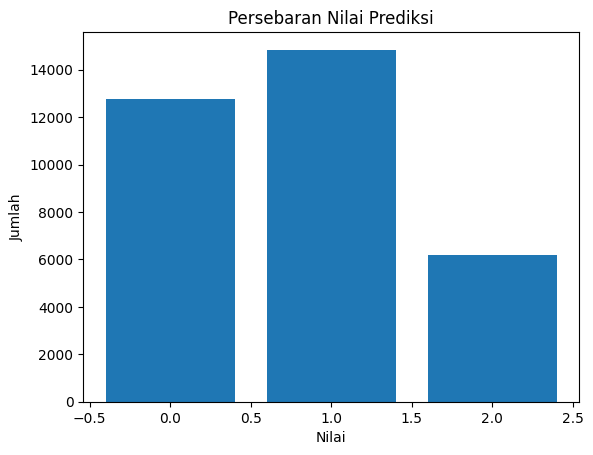

In [56]:
# Menghitung jumlah kemunculan setiap nilai dalam y_pred
value_counts = pd.Series(y_pred).value_counts()

# Membuat DataFrame dari hasil perhitungan
table = pd.DataFrame({'Nilai': value_counts.index, 'Jumlah': value_counts.values})

# Menampilkan tabel
print(table)

# Membuat grafik batang
plt.bar(value_counts.index, value_counts.values)

# Memberikan label sumbu dan judul
plt.xlabel('Nilai')
plt.ylabel('Jumlah')
plt.title('Persebaran Nilai Prediksi')

# Menampilkan grafik
plt.show()

Dapat dilihat sebaran data hasil prediksi. Dapat diketahui bahwa menggunakan model hasil latih menggunakan data train dapat memprediksi credit score pada data test dengan sebaran nilai 1 (Standard) sebanyak 14.618 data, nilai 2 (Good) sebanyak 6.166 data, dan nilai 0 (Bad) sebanyak 13.024 data